## Load in modules

In [1]:
import geopandas as gpd
import pandas as pd
import math
from shapely.geometry import Point
from pyproj import Transformer
import datetime as dt
import dendropy
import tqdm
import json
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib.patches as mpatches
from matplotlib import cm, ticker


## Load in shapefile and projections

In [2]:
cl_map = gpd.read_file('gadm36_CHL_shp/gadm36_CHL_3_continental.shp')
cl_map = cl_map.to_crs('epsg:3395')

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3395")

cl_map.crs

<Derived Projected CRS: EPSG:3395>
Name: WGS 84 / World Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World between 80°S and 84°N.
- bounds: (-180.0, -80.0, 180.0, 84.0)
Coordinate Operation:
- name: World Mercator
- method: Mercator (variant A)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Process geometry for mapping and date formats

In [3]:
def get_date_str(dec_date):
    date = dt.datetime(int(dec_date), 1, 1) + dt.timedelta(days = (dec_date % 1) * 365)

    return dt.datetime.strftime(date, '%Y-%m-%d')

def get_displacement(pos_1, pos_2, km=True):
    R = 6371e3 ## Earth's radius in meters
    phi_1 = pos_1.y*math.pi/180
    phi_2 = pos_2.y*math.pi/180
    delta_phi = (pos_2.y - pos_1.y)*math.pi/180
    delta_lambda = (pos_2.x - pos_1.x)*math.pi/180
    
    a = math.sin(delta_phi/2)**2 + math.cos(phi_1)*math.cos(phi_2)*math.sin(delta_lambda/2)**2
    c = 2*math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R*c
    
    return (d/1000 if km else d) ## return shortest distance in metres


## Read and process MCC tree

In [57]:
mcc_treefile = 'MCC_Mu_TL_82.tree'
tree = dendropy.Tree.get(path=mcc_treefile, schema='nexus')
most_recent_dec_date = 2021.723

## name internal nodes
count = 0
for node in tree.preorder_node_iter():
    count += 1
    node.label = count
    
## store information from tree
edge_info = []
for edge in tqdm.tqdm(tree.postorder_edge_iter()):
    if edge.tail_node:
        head_node = edge.tail_node ## tail_node in edge indicates older node (confusing defintion)
        head_dec_date = most_recent_dec_date - float(head_node.annotations['height'].value)
        head_date = get_date_str(head_dec_date)
        original_head_lat = head_node.annotations['coordinates2'].value
        original_head_long = head_node.annotations['coordinates1'].value
        
        tail_node = edge.head_node ## head_node in edge indicates younger node (confusing defintion)
        tail_dec_date = most_recent_dec_date - float(tail_node.annotations['height'].value)
        tail_date = get_date_str(tail_dec_date)
        original_tail_lat = tail_node.annotations['coordinates2'].value
        original_tail_long = tail_node.annotations['coordinates1'].value
        
        geo_dist = get_displacement(Point(float(original_head_long), float(original_head_lat)),
                                    Point(float(original_tail_long), float(original_tail_lat)))
        
        proj_head_long, proj_head_lat = transformer.transform(original_head_long, original_head_lat)
        proj_tail_long, proj_tail_lat = transformer.transform(original_tail_long, original_tail_lat)

        head_point = Point(float(proj_head_long), float(proj_head_lat))
        tail_point = Point(float(proj_tail_long), float(proj_tail_lat))
                
        head_comuna = None
        tail_comuna = None
        head_comuna_amb = False
        tail_comuna_amb = False
        head_comuna_amb_dists = {}
        tail_comuna_amb_dists = {}
        for Comuna, polygon in zip(cl_map.NAME_3.values, cl_map.geometry.values):
            head_comuna_amb_dist = polygon.distance(head_point)
            head_comuna_amb_dists[Comuna] = head_comuna_amb_dist
            tail_comuna_amb_dist = polygon.distance(tail_point)
            tail_comuna_amb_dists[Comuna] = tail_comuna_amb_dist
            if polygon.contains(head_point):
                head_comuna = Comuna
            if polygon.contains(tail_point):
                tail_comuna = Comuna
            if head_comuna and tail_comuna:
                break
        else:
            if not head_comuna:
                head_comuna_amb = True
                min_dist_comuna = sorted([(Comuna, dist) for Comuna, dist in head_comuna_amb_dists.items()],
                                       key=lambda x: x[1])[0]
                head_comuna = min_dist_comuna[0]
            if not tail_comuna:
                tail_comuna_amb = True
                min_dist_comuna = sorted([(Comuna, dist) for Comuna, dist in tail_comuna_amb_dists.items()],
                                       key=lambda x: x[1])[0]
                tail_comuna = min_dist_comuna[0]
                
                
        edge_info.append(
            {
                'head_node': head_node.label,
                'tail_node': tail_node.label,
                'length': edge.length,
                'geo_distance': geo_dist,
                'head_lat_3395': proj_head_lat,
                'head_long_3395': proj_head_long,
                'tail_lat_3395': proj_tail_lat,
                'tail_long_3395': proj_tail_long,
                'head_lat_4326': original_head_lat,
                'head_long_4326': original_head_long,
                'tail_lat_4326': original_tail_lat,
                'tail_long_4326': original_tail_long,
                'head_comuna': head_comuna,
                'head_comuna_amb': head_comuna_amb,
                'tail_comuna': tail_comuna,
                'tail_comuna_amb': tail_comuna_amb,
                'head_date': head_date,
                'head_dec_date': head_dec_date,
                'tail_date': tail_date,
                'tail_dec_date': tail_dec_date
            }
        )


425it [00:09, 43.38it/s]


In [58]:
mcc_edge_df = pd.DataFrame(edge_info)
mcc_edge_df


,head_node,tail_node,length,geo_distance,head_lat_3395,head_long_3395,tail_lat_3395,tail_long_3395,head_lat_4326,head_long_4326,tail_lat_4326,tail_long_4326,head_comuna,head_comuna_amb,tail_comuna,tail_comuna_amb,head_date,head_dec_date,tail_date,tail_dec_date
0,36,37,0.018100,18.740464,-3.970418e+06,-7.861743e+06,-4.027279e+06,-7.872038e+06,-70.62324042524257,-33.741547901217004,-70.71571834151665,-34.16720515464316,Pirque,False,Machali,False,2021-09-02,2021.669284,2021-09-08,2021.687384
1,36,38,0.045498,212.165137,-3.970418e+06,-7.861743e+06,-4.450836e+06,-8.033341e+06,-70.62324042524257,-33.741547901217004,-72.16473318674883,-37.269321525102036,Pirque,False,Los Angeles,False,2021-09-02,2021.669284,2021-09-18,2021.714782
2,35,36,0.003236,12.564321,-3.933130e+06,-7.854623e+06,-3.970418e+06,-7.861743e+06,-70.5592757362725,-33.46124610579058,-70.62324042524257,-33.741547901217004,San Jode de Maipo,False,Pirque,False,2021-09-01,2021.666048,2021-09-02,2021.669284
3,35,39,0.002158,2.207180,-3.933130e+06,-7.854623e+06,-3.932770e+06,-7.852415e+06,-70.5592757362725,-33.46124610579058,-70.53944661619367,-33.45853565982505,San Jode de Maipo,False,San Jode de Maipo,False,2021-09-01,2021.666048,2021-09-01,2021.668206
4,34,35,0.003199,2.952370,-3.932073e+06,-7.857564e+06,-3.933130e+06,-7.854623e+06,-70.58569483343217,-33.453290011710486,-70.5592757362725,-33.46124610579058,San Jode de Maipo,False,San Jode de Maipo,False,2021-08-30,2021.662849,2021-09-01,2021.666048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,422,423,0.082356,33.052559,-3.934554e+06,-7.863023e+06,-4.017005e+06,-7.887093e+06,-70.63474007487251,-33.47197318233443,-70.8509596345939,-34.09045143417196,Puente Alto,False,Olivar,False,2021-05-21,2021.385850,2021-06-20,2021.468206
420,422,424,0.008383,2.425903,-3.934554e+06,-7.863023e+06,-3.928355e+06,-7.861313e+06,-70.63474007487251,-33.47197318233443,-70.61937336688733,-33.42528714403211,Puente Alto,False,Santiago,False,2021-05-21,2021.385850,2021-05-24,2021.394233
421,2,422,0.001704,0.296160,-3.935462e+06,-7.863179e+06,-3.934554e+06,-7.863023e+06,-70.63614114887666,-33.478804581701986,-70.63474007487251,-33.47197318233443,Puente Alto,False,Puente Alto,False,2021-05-21,2021.384146,2021-05-21,2021.385850
422,1,2,0.054148,94.029790,-4.139600e+06,-7.939401e+06,-3.935462e+06,-7.863179e+06,-71.3208510896945,-35.00167733477155,-70.63614114887666,-33.478804581701986,Sagrada Familia,False,Puente Alto,False,2021-05-01,2021.329998,2021-05-21,2021.384146


In [59]:
mcc_edge_df.to_csv('Mu_TL_82.tsv',
                   sep='\t', index=False)


In [60]:
tree.write(path='MCC_Mu_TL_82_node_labelled.tree', schema='newick')


## Plot viral movements on map

In [65]:
mcc_edge_df = pd.read_csv('Alpha_TL_13.tsv', sep='\t')
mcc_edge_df = mcc_edge_df.sort_values('head_date', ascending=False)
mcc_edge_df


,head_node,tail_node,length,geo_distance,head_lat_3395,head_long_3395,tail_lat_3395,tail_long_3395,head_lat_4326,head_long_4326,tail_lat_4326,tail_long_4326,head_comuna,head_comuna_amb,tail_comuna,tail_comuna_amb,head_date,head_dec_date,tail_date,tail_dec_date
94,102,103,0.003324,80.235628,-4.755230e+06,-8.131147e+06,-4.409985e+06,-8.120760e+06,-73.043337,-39.422471,-72.950032,-36.975465,Mariquina,False,Coronel,False,2021-01-30,2021.081320,2021-01-31,2021.084644
95,102,104,0.008804,17.193553,-4.755230e+06,-8.131147e+06,-4.805487e+06,-8.144130e+06,-73.043337,-39.422471,-73.159965,-39.771741,Mariquina,False,Mariquina,False,2021-01-30,2021.081320,2021-02-02,2021.090124
103,111,112,0.017876,0.502725,-3.943841e+06,-7.860993e+06,-3.943344e+06,-7.860509e+06,-70.616498,-33.541858,-70.612150,-33.538123,Pirque,False,Pirque,False,2021-01-17,2021.044850,2021-01-23,2021.062726
104,111,113,0.031574,1.320309,-3.943841e+06,-7.860993e+06,-3.943593e+06,-7.862313e+06,-70.616498,-33.541858,-70.628356,-33.539996,Pirque,False,Pirque,False,2021-01-17,2021.044850,2021-01-28,2021.076424
88,96,98,0.080431,226.973799,-3.944840e+06,-7.862417e+06,-3.153568e+06,-7.859218e+06,-70.629291,-33.549377,-70.600554,-27.397523,Pirque,False,Caldera,False,2021-01-16,2021.042569,2021-02-14,2021.123000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,3,107,0.200820,1.433790,-3.947217e+06,-7.864784e+06,-3.948176e+06,-7.866194e+06,-70.650556,-33.567254,-70.663227,-33.574461,Pirque,False,Pirque,False,2020-08-20,2020.636473,2020-11-01,2020.837293
114,2,3,0.020213,0.229798,-3.947689e+06,-7.864973e+06,-3.947217e+06,-7.864784e+06,-70.652257,-33.570797,-70.650556,-33.567254,Pirque,False,Pirque,False,2020-08-12,2020.616260,2020-08-20,2020.636473
117,2,118,0.217551,2.706461,-3.947689e+06,-7.864973e+06,-3.947423e+06,-7.862265e+06,-70.652257,-33.570797,-70.627926,-33.568801,Pirque,False,Pirque,False,2020-08-12,2020.616260,2020-10-31,2020.833811
118,1,2,0.009202,0.825630,-3.948618e+06,-7.865759e+06,-3.947689e+06,-7.864973e+06,-70.659311,-33.577787,-70.652257,-33.570797,Pirque,False,Pirque,False,2020-08-09,2020.607058,2020-08-12,2020.616260


In [66]:
dec_date_df = pd.read_csv('Alpha_TL_13_dec_date_2.tsv', sep='\t')
date_dec_map = dict(zip(dec_date_df.date.values, dec_date_df.dec_date.values))

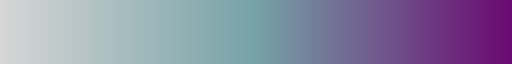

In [67]:
all_dates = [date_dec_map[x] for x in 
             (mcc_edge_df.head_date.unique().tolist() + mcc_edge_df.tail_date.unique().tolist())]
norm = Normalize(vmin=min(all_dates), vmax=max(all_dates))

cmap = LinearSegmentedColormap.from_list("", ["#d6d6d6", "#76a2a7", "#6a0971"])

colour_dict = {}
for date in all_dates:
    colour_dict[date] = cmap(norm(date))

cmap

124it [00:00, 318.37it/s]
/var/folders/60/wpm_ns9n58z6yb2bc5mnfqym0000gp/T/ipykernel_8766/1797457463.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar.set_ticklabels(new_ticks)


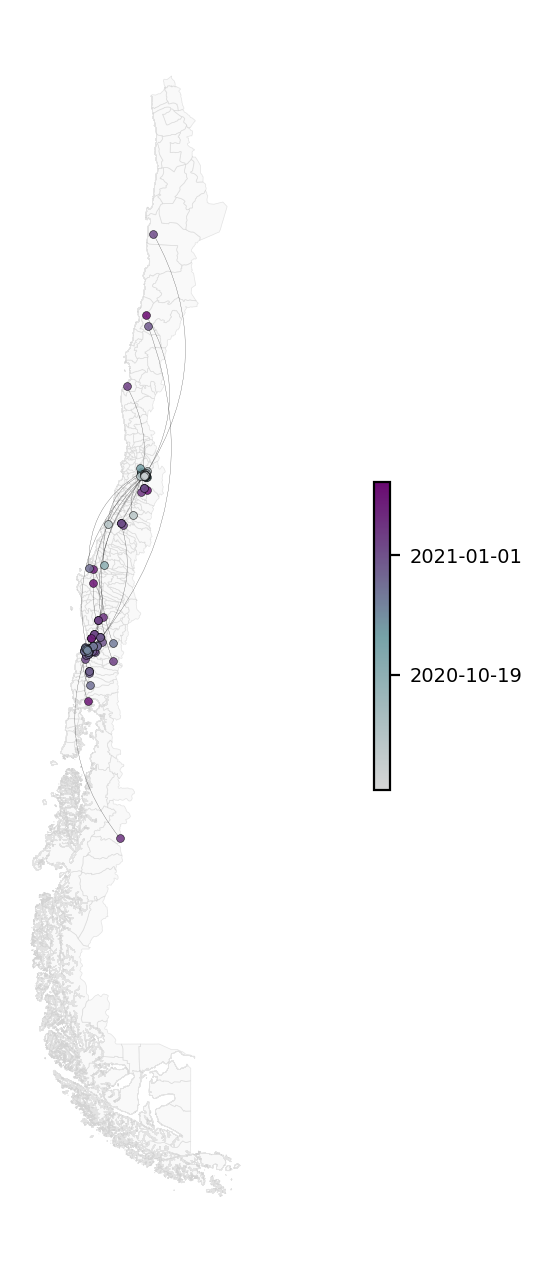

['2020-08-06', '2020-10-19', '2021-01-01', '2021-03-15']

In [68]:
# cutoff_date = '2021-01-30'

fig, ax = plt.subplots(1,1, figsize=(16, 8), dpi=200)
cl_map.plot(ax=ax, color='whitesmoke', ec='lightgrey', linewidth=0.25, alpha=0.6)

for index, row in tqdm.tqdm(mcc_edge_df.iterrows()):
    head_pos = (row['head_long_3395'], row['head_lat_3395'])
    tail_pos = (row['tail_long_3395'], row['tail_lat_3395'])
    head_date = date_dec_map[row['head_date']]
    tail_date = date_dec_map[row['tail_date']]

    kw = dict(color="black", linewidth=0.1, alpha=0.75)

    liney = mpatches.FancyArrowPatch(head_pos, tail_pos, shrinkA=0, shrinkB=0,
                                     arrowstyle="-", connectionstyle="arc3, rad=.3", **kw)
    
    ax.add_patch(liney)

    ax.scatter(head_pos[0], head_pos[1], s=8, color=colour_dict[head_date], edgecolor='black', linewidth=0.2,
               alpha=0.85, zorder=5)
    ax.scatter(tail_pos[0], tail_pos[1], s=8, color=colour_dict[tail_date], edgecolor='black', linewidth=0.2,
               alpha=0.85, zorder=6)

bar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.25)

new_ticks = []
for i in bar.get_ticks():
    new_ticks.append(get_date_str(i))
#bar.set_ticks(bar.get_ticks())
bar.set_ticklabels(new_ticks)
bar.ax.tick_params(labelsize=7)
bar.ax.locator_params(nbins=4)

ax.set_axis_off()
        
plt.savefig("Alpha_TL_13_map.pdf", bbox_inches='tight', dpi=200)

plt.show()
new_ticks